# Calculate Nino 3.4 index to check if eruptions line up with El Nino events
This script opens up all the CMIP6 historical model run files with data on precipitation pr and surface temperature tas and loops over the files. It calculates the Nino3.4 index for the data to test which years have an El Nino event and if they occur after volcanic eruptions. 


In [1]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration

In [2]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [3]:
# use this to reload the function file if I make any edits to it
func = reload(func) 
func2 = reload(func2)

In [4]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/ts/gr1.5/

v20200302


In [5]:
!ls /g/data/eg3/jxb548/OBSDATA/ersstv5.1854_2019.r240x120.nc

/g/data/eg3/jxb548/OBSDATA/ersstv5.1854_2019.r240x120.nc


In [6]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
ts_dir = '/historical/r1i1p1f1/Amon/ts/gr1.5/'
print(institution_dir, tas_dir, pr_dir, ts_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/ /historical/r1i1p1f1/Amon/ts/gr1.5/


## Read in model data

In [7]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model MPI-ESM1-2-HR has different time so is now removed
Model E3SM-1-0 has different time so is now removed
Model EC-Earth3-Veg has different time so is now removed
45 models have been successfully loaded into an xarray


In [8]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
47 models have been successfully loaded into an xarray


In [9]:
models_ts = func.read_models(institution_dir, ts_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model E3SM-1-0 has different time so is now removed
47 models have been successfully loaded into an xarray


In [10]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_ts.model), drop = True)
models_ts = models_ts.where(models_ts.model.isin(models_tas.model), drop = True)

#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_ts.model)

True

In [11]:
# get rid of models with issues
models = models_ts.drop_sel(model=['CIESM'])

In [12]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## Read in obs data

In [42]:
# read in obs data from ersst dataset 
ersst_path = '/g/data/eg3/jxb548/OBSDATA/ersstv5.1854_2019.r240x120.nc'
ersst = xr.open_dataset(ersst_path)
if 'time_bnds' in ersst:
    del ersst['time_bnds']
ersst

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 240, time: 1989)
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2019-09-01
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * lat      (lat) float64 -89.25 -87.75 -86.25 -84.75 ... 86.25 87.75 89.25
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.9.8 (https://...
    history:                   Thu Dec 03 18:13:58 2020: cdo remapcon,r240x12...
    source:                    In situ data: ICOADS R3.0 before 2015, NCEP in...
    institution:               This version written at NOAA/ESRL PSD: obtaine...
    Conventions:               CF-1.6, ACDD-1.3
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    geospatial_lon_min:        -1.0
    geospatial_lon_max:        359.0
    geospatial_laty_max:       89.0
    geospatial_laty_min:       -89.0
    geospatial_lat_max:        89.0
    geospatial_lat_min:        -89.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    cdm_data_type:             Grid
    project:                   NOAA Extended Reconstructed Sea Surface Temper...
    original_publisher_url:    http://www.ncdc.noaa.gov
    References:                https://www.ncdc.noaa.gov/data-access/marineoc...
    title:                     NOAA ERSSTv5 (in situ only)
    citation:                  Huang et al, 2017: Extended Reconstructed Sea ...
    platform:                  Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    standard_name_vocabulary:  CF Standard Name Table (v40, 25 January 2017)
    processing_level:          NOAA Level 4
    metadata_link:             :metadata_link = https://doi.org/10.7289/V5T72...
    creator_name:              Boyin Huang (original)
    date_created:              2017-06-30T12:18:00Z (original)
    product_version:           Version 5
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2019-10-03
    CDO:                       Climate Data Operators version 1.9.8 (https://...

In [47]:
# convert to month end frequency (rahter than month start)
ersst = ersst.resample(time = 'M').mean()

## Area weighting
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [14]:
# area weighting 
models_w = models*np.cos(models_ts.lat*(np.pi/180))

In [48]:
ersst_w = ersst*np.cos(ersst.lat*(np.pi/180))

## Nino 3.4

In [16]:
# add the multi-model mean to the data-array
# models_w_mmm = func.add_mmm(models_w)

# calculate the multi-model mean
mmm = models_w.mean(dim='model')

In [56]:
# calculate the nino3.4 index for all models for every month
nino34_index = func.nino34(models_w, '1850-01', '1880-01')

In [18]:
# calculate the nino3.4 index for multi-model mean for every month
nino34_mmm = func.nino34(mmm, '1850-01', '1880-01')

In [49]:
# calculate the nino3.4 index for obs data for every month
nino34_obs = func.nino34(ersst_w, '1850-01', '1880-01')

### Threshold

In [20]:
# set the threshold for el nino/la nia events
THOLD = 0.4

# Graphs

In [21]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

<AxesSubplot:ylabel='Sea surface temperature anomaly [$\\degree$C]'>

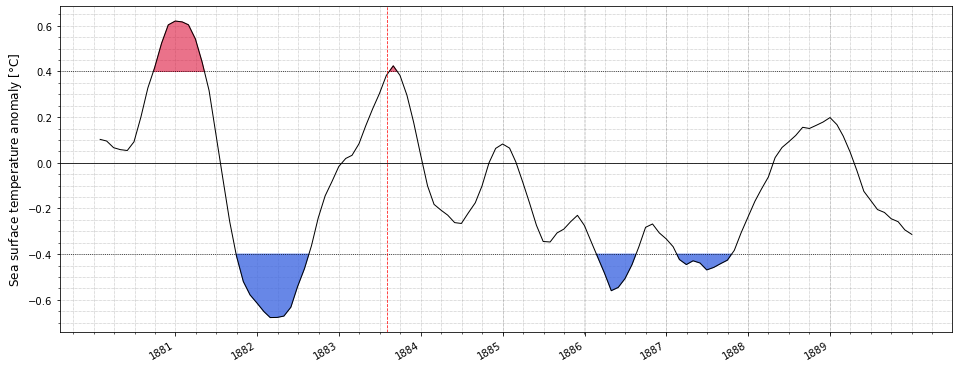

In [22]:
# plot time series of nino3.4 index for the multimodel mean dataset 
fig, axes = plt.subplots(figsize=(16,6))

func2.nino34_plot(nino34_mmm.ts.sel(time=slice('1880-01','1889-12')), e_date, THOLD, ax = axes)

#plt.savefig('nino34_plot_mmm.png', dpi=300, bbox_inches='tight')

<AxesSubplot:ylabel='Sea surface temperature anomaly [$\\degree$C]'>

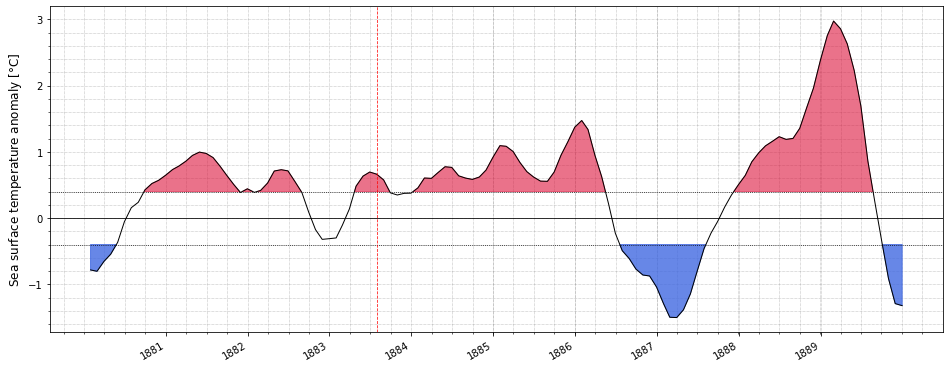

In [50]:
# plot time series of nino3.4 index for the obs ERSST dataset 
fig, axes = plt.subplots(figsize=(16,6))

func2.nino34_plot(nino34_obs.sst.sel(time=slice('1880-01','1889-12')), e_date, THOLD, ax = axes)

#plt.savefig('nino34_plot_obs.png', dpi=300, bbox_inches='tight')

## next i want to classify each year as either el nino, la nino or neutral and then plot the results in a table 
to do this i need to count the number of el nino/la nina/ neutral events each year 
record count of dominant event for the year
then write the count and colour code (red el nino, blue la nina, white/grey neutral)  

In [57]:
# select out the years near the eruption
nino34_obs = nino34_obs.sel(time=slice('1883-01','1888-12'))
nino34_index = nino34_index.sel(time=slice('1883-01','1888-12'))

In [58]:
# add model dimension to obs dataset
ds = []
ds.append(nino34_obs)
obs = xr.concat(ds, dim='model', coords = 'minimal')
obs.coords['model'] = [' ERSST Observations']
# rename sst variable to ts so we can concat the datasets
obs = obs.rename_vars({'sst': 'ts'})

In [59]:
# append the mmm to the rest of the anomaly array
ds2=[]
ds2.append(nino34_index)
ds2.append(obs)
nino34_index = xr.concat(ds2, dim='model', coords = 'minimal', compat='override')

## percentage checks 

In [29]:
# # check which months are above the threshold for el nino and la nina and assign 1 for nino, -1 for nina
# nino_month = xr.where(nino34_index>=THOLD, 1, 0)
# nina_month = xr.where(nino34_index<=-THOLD, -1, 0)

# nino34month = nino_month + nina_month

In [38]:
# # counts the number of el nino months in the time period and records it as a percentage 
# nino_count = 100*(nino34_index.where(nino34_index>=THOLD).count('time') / nino34_index.count('time'))
# # counts the number of la nina months in the time period and records it as a percentage 
# nina_count = 100*(nino34_index.where(nino34_index<=-THOLD).count('time') / nino34_index.count('time'))
# # counts the number of neutral months in the time period and records it as a percentage 
# neutral_count = 100-nino_count-nina_count #fixed neutral count
# print(nino_count.ts.mean(dim='model').values, nina_count.ts.mean(dim='model').values, neutral_count.ts.mean(dim='model').values)

21.156330749354005 27.713178294573645 32.12568188343383


# Produce a table showing onset date of el nino events (anomalies above threshold that last longer than 5 months) 

In [65]:
func = reload(func)

In [66]:
# find the nino/nina events over the specified threshold and lasting longer than 5 months
ENSO_events_04 = func.find_ENSO(nino34_index, 0.4)

In [93]:
ENSO_events_04.to_xarray().model

<xarray.DataArray 'model' (model: 43)>
array([' ERSST Observations', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR',
       'AWI-ESM-1-1-LR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0',
       'CAS-ESM2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2',
       'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'CanESM5', 'E3SM-1-1', 'E3SM-1-1-ECA',
       'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-Veg-LR', 'FGOALS-f3-L',
       'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
       'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'IITM-ESM', 'INM-CM5-0',
       'IPSL-CM6A-LR', 'KACE-1-0-G', 'MIROC6', 'MPI-ESM-1-2-HAM',
       'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorCPM1', 'NorESM2-LM',
       'NorESM2-MM', 'SAM0-UNICON', 'TaiESM1'], dtype=object)
Coordinates:
  * model    (model) object ' ERSST Observations' 'ACCESS-CM2' ... 'TaiESM1'

In [98]:
# find the nino/nina events over the specified threshold and lasting longer than 5 months
ENSO_events_05 = func.find_ENSO(nino34_index, 0.5)

In [99]:
# find the nino/nina events over the specified threshold and lasting longer than 5 months
ENSO_events_08 = func.find_ENSO(nino34_index, 0.8)

In [ ]:
rows = list(dataset.index)
rows.remove(' ERSST Observations')
df = dataset.loc[[*rows, ' ERSST Observations']]

## I think i need to put this in my find_ENSO function as soon as I've put my coordinates in or just before i pivot the results

In [101]:
# create an array of zeros for the models which never exceed the nino threshold of length time 
if len(nino34_index.model) != len(ENSO_events_08.to_xarray().model):
    
    mod_zero = nino34_index.sel(model=' ERSST Observations')*0
    # find which models are NOT included in the obs xarray 
    missing_mods = nino34_index.model.where(~nino34_index.model.isin(ENSO_events_08.to_xarray().model), drop = True)
    print(missing_mods)
    dataset=[]
    names=[]

    for m, mods in enumerate(missing_mods):
        dataset.append(mod_zero)
        names.append(mods)

    ENSO_events08 = xr.concat(dataset, dim='model', coords = 'minimal')
    ENSO_events08.coords['model'] = missing_mods

<xarray.DataArray 'model' (model: 5)>
array(['E3SM-1-1-ECA', 'INM-CM4-8', 'INM-CM5-0', 'NorESM2-LM', 'TaiESM1'],
      dtype=object)
Coordinates:
  * model    (model) object 'E3SM-1-1-ECA' 'INM-CM4-8' ... 'TaiESM1'


In [110]:
if type(ENSO_events08) == xr.core.dataset.Dataset:
    print('xr')

xr


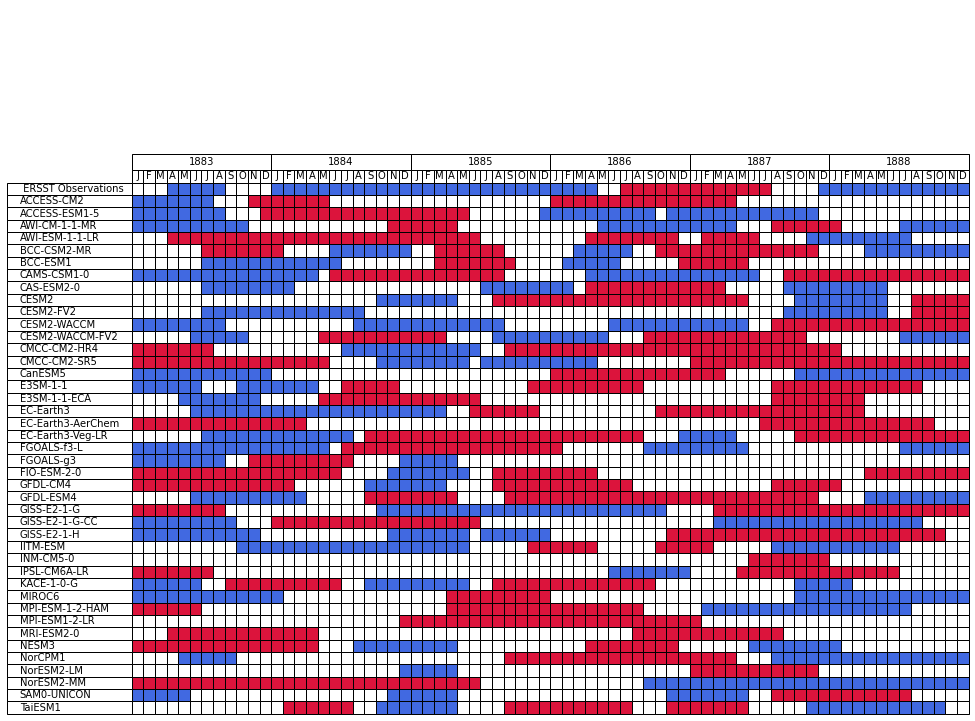

In [68]:
# plot the results in a table 
fig, ax = plt.subplots(1, figsize=(15,10))

# call function to make the table
func2.nino34_table(ENSO_events_04)

# save table as pdf 
plt.savefig('nino3.4_table_0.4thold.png', dpi=300, bbox_inches='tight')

<AxesSubplot:>

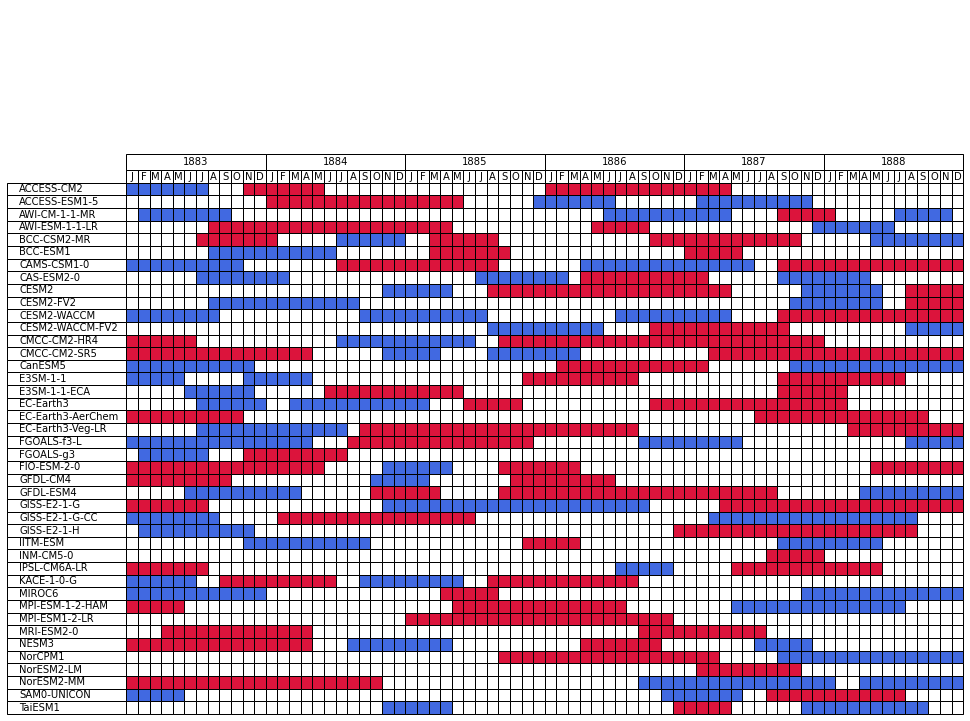

In [76]:
# plot the results in a table 
fig, ax = plt.subplots(1, figsize=(15,10))

# call function to make the table
func2.nino34_table(ENSO_events_05)

# save table as pdf 
plt.savefig('nino3.4_table_0.5thold.pdf', dpi=300, bbox_inches='tight')

IndexError: index 3 is out of bounds for axis 0 with size 3

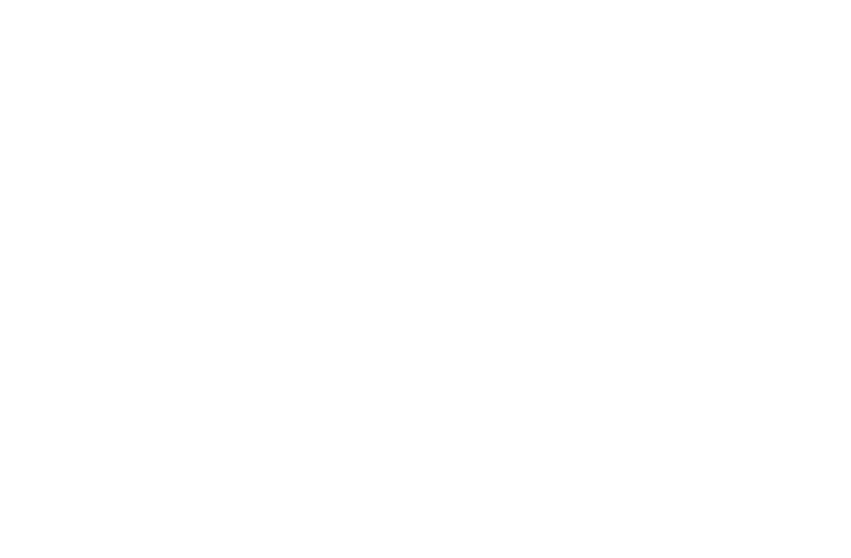

In [112]:
# plot the results in a table 
fig, ax = plt.subplots(1, figsize=(15,10))

# call function to make the table
func2.nino34_table(ENSO_events08)

# save table as pdf 
plt.savefig('nino3.4_table_0.8thold.pdf', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10))

# call function to make the table
func2.nino34_table(dataset)

# save table as pdf 
plt.savefig('nino3.4_table_0.5thold.pdf', dpi=300, bbox_inches='tight')